In [1]:
# TODO: cant we do most of the latter part using confidence_intervals.py?

In [2]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [3]:
import logging

import holoviews as hv
import hvplot.polars  # noqa
import polars as pl
from icecream import ic
from polars import col

from src.data.database_manager import DatabaseManager
from src.features.transforming import merge_dfs
from src.log_config import configure_logging
from src.plots.utils import prepare_multiline_hvplot

configure_logging(
    stream_level=logging.DEBUG, ignore_libs=("Comm", "bokeh", "tornado", "matplotlib")
)
logger = logging.getLogger(__name__.rsplit(".", maxsplit=1)[-1])

hv.output(widget_location="bottom", size=130)
pl.Config.set_tbl_rows(12)

polars.config.Config

In [4]:
db = DatabaseManager()

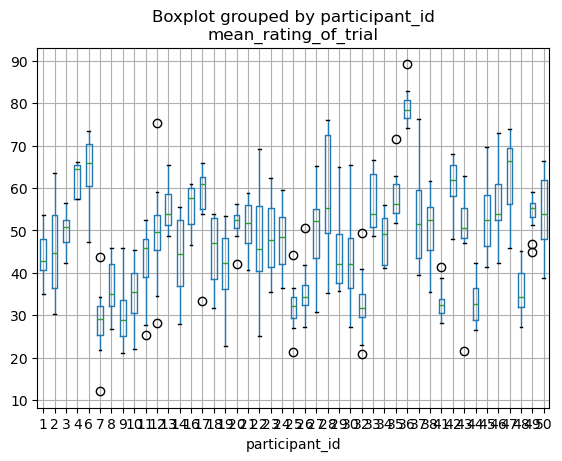

In [5]:
query = """
SELECT mean(rating) AS mean_rating_of_trial, trial_id, participant_id
FROM raw_stimulus
GROUP BY trial_id, participant_id, trial_id
ORDER BY participant_id, trial_id;
;
"""
with db:
    df = db.execute(query).pl()
df.to_pandas().boxplot(  # boxplots look better in pandas
    column="mean_rating_of_trial", by="participant_id"
);

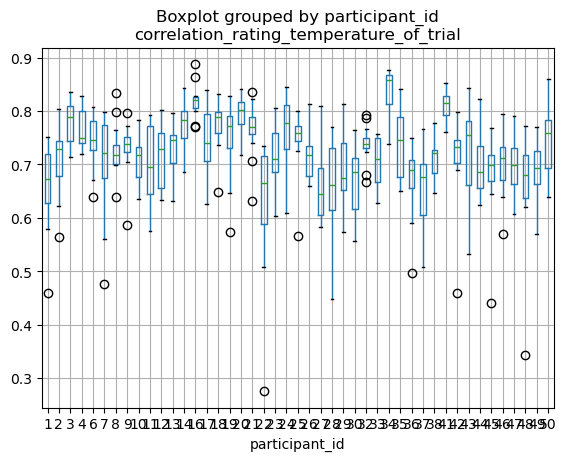

In [6]:
query = """
SELECT corr(rating, temperature) AS correlation_rating_temperature_of_trial, trial_id, participant_id
FROM raw_stimulus
GROUP BY trial_id, participant_id, trial_id
ORDER BY correlation_rating_temperature_of_trial DESC
;
"""
with db:
    df = db.execute(query).pl()
df.to_pandas().boxplot(
    column="correlation_rating_temperature_of_trial", by="participant_id"
);

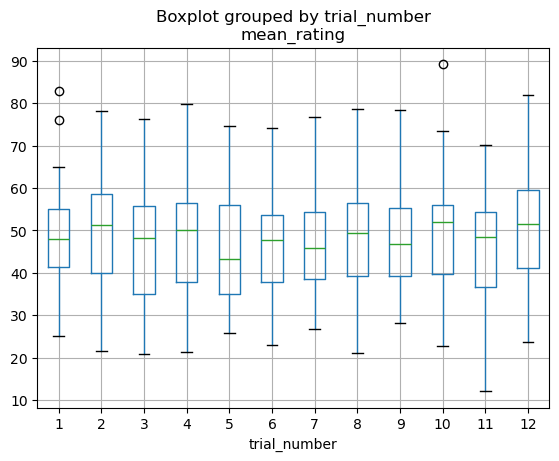

In [7]:
query = """
SELECT mean(rating) AS mean_rating, trial_id, trial_number, participant_id
FROM raw_stimulus
WHERE NOT participant_id = 5
GROUP BY trial_id, participant_id, trial_id, trial_number
ORDER BY mean_rating DESC
;
"""
with db:
    df = db.execute(query).pl()
df.to_pandas().boxplot(column="mean_rating", by="trial_number");

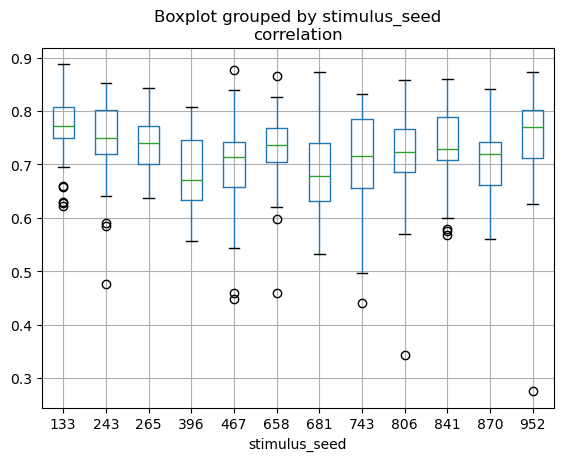

In [10]:
query = """
SELECT
    trial_id,
    s.trial_number,
    s.participant_id,
    stimulus_seed,
    skin_patch,
    corr(rating, temperature) as correlation
FROM raw_stimulus as s
-- get the seeds from trials
JOIN trials as t USING (trial_id)
WHERE NOT s.participant_id = 5
GROUP BY s.trial_id, s.participant_id, s.trial_number, stimulus_seed, skin_patch
ORDER BY s.participant_id, trial_id
"""

with db:
    df = db.execute(query).pl()
df.to_pandas().boxplot(column="correlation", by="stimulus_seed");

In [11]:
with db:
    stimulus = db.get_table("preprocess_stimulus")
    trials = db.get_table("trials")


# Nrmalize timestamps
normalized_timestamps = stimulus.with_columns(
    [
        (col("timestamp") - col("timestamp").min().over("trial_id")).alias(
            "normalized_timestamp"
        )
    ]
)

df = merge_dfs(
    dfs=[normalized_timestamps, trials],
    on=["trial_id", "participant_id", "trial_number"],
).drop("duration")
df

trial_id,trial_number,participant_id,rownumber,timestamp,temperature,rating,normalized_timestamp,stimulus_seed,skin_patch,timestamp_start,timestamp_end
u16,u8,u8,u32,f64,f64,f64,f64,u16,u8,f64,f64
23,1,3,0,184836.2971,0.0,0.93625,0.0,658,1,184806.3783,364835.4139
23,1,3,1,184969.6852,0.000148,0.93625,133.3881,658,1,184806.3783,364835.4139
23,1,3,2,185069.4183,0.000593,0.93625,233.1212,658,1,184806.3783,364835.4139
23,1,3,3,185170.1492,0.001334,0.93625,333.8521,658,1,184806.3783,364835.4139
23,1,3,4,185269.4517,0.00237,0.93625,433.1546,658,1,184806.3783,364835.4139
23,1,3,5,185369.8286,0.003702,0.93625,533.5315,658,1,184806.3783,364835.4139
…,…,…,…,…,…,…,…,…,…,…,…
513,12,50,21606,2.6956e6,0.031173,0.0,179500.2388,806,1,2.5161e6,2.6961e6
513,12,50,21607,2.6957e6,0.03077,0.0,179598.4851,806,1,2.5161e6,2.6961e6


In [12]:
df.hvplot(x="timestamp", y=["rating", "temperature"], groupby="trial_id", kind="line")

BokehModel(combine_events=True, render_bundle={'docs_json': {'9bfcbf02-8009-49e8-ac2a-a814417fc955': {'version…

In [13]:
df

trial_id,trial_number,participant_id,rownumber,timestamp,temperature,rating,normalized_timestamp,stimulus_seed,skin_patch,timestamp_start,timestamp_end
u16,u8,u8,u32,f64,f64,f64,f64,u16,u8,f64,f64
23,1,3,0,184836.2971,0.0,0.93625,0.0,658,1,184806.3783,364835.4139
23,1,3,1,184969.6852,0.000148,0.93625,133.3881,658,1,184806.3783,364835.4139
23,1,3,2,185069.4183,0.000593,0.93625,233.1212,658,1,184806.3783,364835.4139
23,1,3,3,185170.1492,0.001334,0.93625,333.8521,658,1,184806.3783,364835.4139
23,1,3,4,185269.4517,0.00237,0.93625,433.1546,658,1,184806.3783,364835.4139
23,1,3,5,185369.8286,0.003702,0.93625,533.5315,658,1,184806.3783,364835.4139
…,…,…,…,…,…,…,…,…,…,…,…
513,12,50,21606,2.6956e6,0.031173,0.0,179500.2388,806,1,2.5161e6,2.6961e6
513,12,50,21607,2.6957e6,0.03077,0.0,179598.4851,806,1,2.5161e6,2.6961e6


In [14]:
# Define columns where we don't want to add NaN separators
info_columns = [
    "trial_id",
    "trial_number",
    "participant_id",
    "stimulus_seed",
    "trial_specific_interval_id",  # TODO: remove
    "continuous_interval_id",
    "decreasing_intervals",
    "major_decreasing_intervals",
    "increasing_intervals",
    "plateau_intervals",
    "prolonged_minima_intervals",
]
# Create a new DataFrame with NaN rows
group_by_columns = [x for x in df.columns if x in info_columns]
print(group_by_columns)

nan_df = df.group_by(group_by_columns).agg(
    [
        pl.lit(float("nan")).alias(col)  # following hvplot docs, not using pl.Null
        for col in df.columns
        if col not in info_columns
    ]
)
nan_df

['trial_id', 'trial_number', 'participant_id', 'stimulus_seed']


trial_id,trial_number,participant_id,stimulus_seed,rownumber,timestamp,temperature,rating,normalized_timestamp,skin_patch,timestamp_start,timestamp_end
u16,u8,u8,u16,f64,f64,f64,f64,f64,f64,f64,f64
28,6,3,467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
479,2,48,467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,6,29,265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,4,3,952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189,8,19,841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
508,7,50,396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
…,…,…,…,…,…,…,…,…,…,…,…
485,8,48,743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
451,5,45,806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
prepare_multiline_hvplot(df).hvplot(
    x="normalized_timestamp",
    y=["rating", "temperature"],
    groupby="stimulus_seed",
    kind="line",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'3caccc16-8c06-4f3a-a4c3-f992006add12': {'version…

In [16]:
# After we got all raw data, we can calculate confidence intervals

In [17]:
# NOTE: in some edge cases, there is aexactly one sample for timestamp=180s.
# TODO: Maybe they should be removed.
result = (
    df.with_columns([(col("normalized_timestamp") // 1000 * 1000).alias("time_bin")])
    .group_by(["stimulus_seed", "time_bin"])
    .agg(
        [
            col("rating").mean().alias("avg_rating"),
            col("temperature").mean().alias("avg_temperature"),
            col("rating").std().alias("std_dev"),
            pl.len().alias("sample_size"),
        ]
    )
    .with_columns(
        [
            (
                col("avg_rating") - 1.96 * (col("std_dev") / col("sample_size").sqrt())
            ).alias("ci_lower"),
            (
                col("avg_rating") + 1.96 * (col("std_dev") / col("sample_size").sqrt())
            ).alias("ci_upper"),
        ]
    )
    .select(
        [
            "stimulus_seed",
            "time_bin",
            "avg_rating",
            "ci_lower",
            "ci_upper",
            "avg_temperature",
        ]
    )
    .sort(["stimulus_seed", "time_bin"])
)
result

stimulus_seed,time_bin,avg_rating,ci_lower,ci_upper,avg_temperature
u16,f64,f64,f64,f64,f64
133,0.0,0.455614,0.429745,0.481483,0.0071
133,1000.0,0.587145,0.563152,0.611138,0.052754
133,2000.0,0.653996,0.633188,0.674803,0.141419
133,3000.0,0.689428,0.66875,0.710106,0.265225
133,4000.0,0.73501,0.715516,0.754505,0.413017
133,5000.0,0.78618,0.769145,0.803216,0.56905
…,…,…,…,…,…
952,175000.0,0.129208,0.110259,0.148157,0.160819
952,176000.0,0.102151,0.085021,0.11928,0.118757


In [18]:
result.hvplot(
    x="time_bin",
    y=["avg_rating", "avg_temperature"],
    groupby="stimulus_seed",
    kind="line",
    grid=True,
) * result.hvplot.area(
    x="time_bin",
    y="ci_lower",
    y2="ci_upper",
    groupby="stimulus_seed",
    alpha=0.5,
    line_width=0,
    fill_color="lightblue",
    grid=True,
    ylim=(0, 1),
    xlim=(0, 180 * 1000),
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'ac1b134a-27b1-4841-9bc1-f0c0fbe6ace8': {'version…

In [19]:
# # correlation between temperature and rating
# df.group_by("stimulus_seed").agg(
#     [pl.corr("avg_rating", "avg_temperature").alias("correlation")]
# ).sort("correlation", descending=True)